In [65]:
import time
from pyomo.environ import *
import sys
import os
from os.path import dirname
import  numpy as np
import pandas as pd
import math
from bump_choose import get_bumps_data_mysql
from base.config import *
from datetime import datetime
import matplotlib.pyplot as plt3
from base.mysql_conn import get_conn
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")   #忽略警告
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Simhei'] #显示中文
plt.rcParams['axes.unicode_minus']=False   #显示负号
from IPython.display import display 

In [66]:
def do_predict(flow):
        return 1.6359 + 1.0057 * pow(10,-4) * flow + -2.0706 * pow(10,-8) * pow(flow, 2)

# 全部工频拟合

In [67]:
gongpin_list= ['日仪增输日照站1P-5泵入口压力检测','日仪增输日照站1P-5泵出口压力检测','日仪增输日照站1P-6泵入口压力检测','日仪增输日照站1P-6泵出口压力检测'
              ,'日仪增输东海站2P-1泵入口压力检测','日仪增输东海站2P-1泵出口压力检测','日仪增输东海站2P_2泵入口压力检测','日仪增输东海站2P_2泵出口压力检测'
              ,'日仪增输淮安站3P-5泵入口压力检测','日仪增输淮安站3P-5泵出口压力检测','日仪增输淮安站3P_6泵入口压力检测','日仪增输淮安站3P_6泵出口压力检测'
              ,'日仪增输观音站4P-1泵入口压力检测','日仪增输观音站4P-1泵出口压力检测','日仪增输观音站4P_2泵入口压力检测','日仪增输观音站4P_2泵出口压力检测']

In [68]:
time_delta = 60*5  # 时间差设置

开始拟合日照站1P-5泵
拟合函数为： y = -0.000000094675 * x^2 + 0.0007256603 * x + 0.3259694955


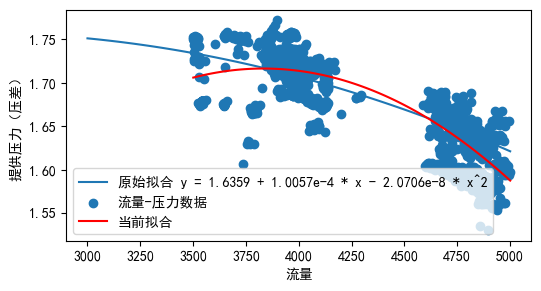

开始拟合日照站1P-6泵
拟合函数为： y = -0.000000005331 * x^2 + -0.0000271323 * x + 1.9025624965


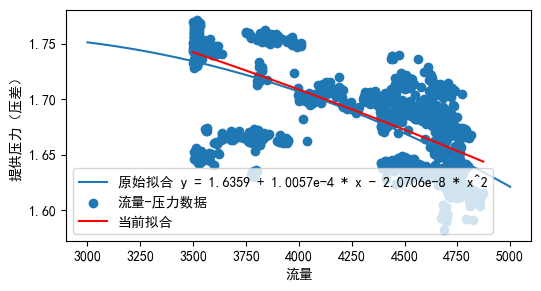

开始拟合东海站2P-1泵
拟合函数为： y = -0.000000019866 * x^2 + 0.0000678761 * x + 1.7679022152


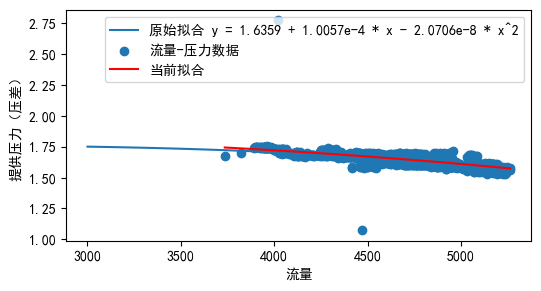

开始拟合东海站2P_2泵
拟合函数为： y = -0.000000108118 * x^2 + 0.0008077043 * x + 0.2038966221


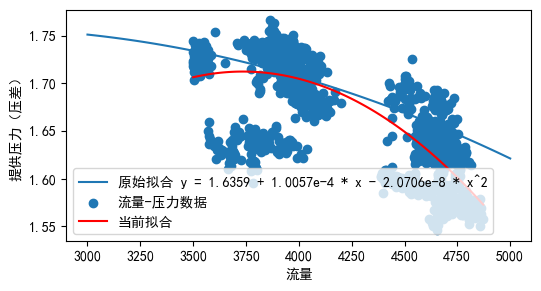

开始拟合淮安站3P-5泵
拟合函数为： y = -0.000000041413 * x^2 + 0.0002705021 * x + 1.2816978385


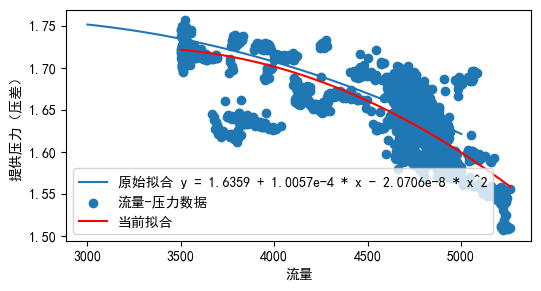

开始拟合淮安站3P_6泵
拟合函数为： y = -0.000000056491 * x^2 + 0.0004074756 * x + 0.9866817504


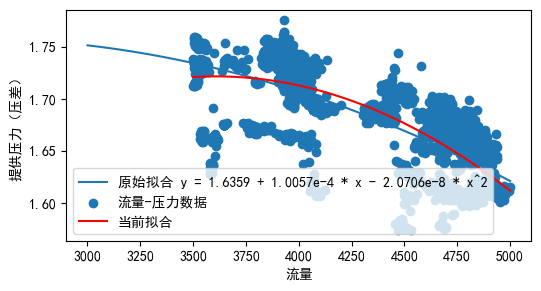

开始拟合观音站4P-1泵
拟合函数为： y = -0.000000044731 * x^2 + 0.0002942832 * x + 1.2588246840


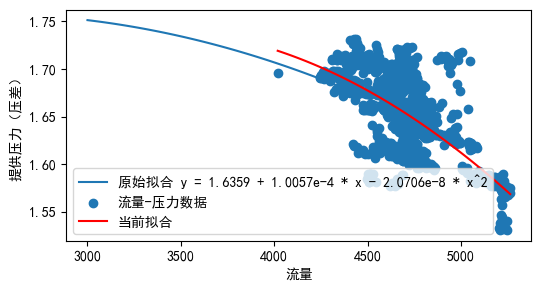

开始拟合观音站4P_2泵
拟合函数为： y = -0.000000170644 * x^2 + 0.0014647177 * x + -1.4568069403


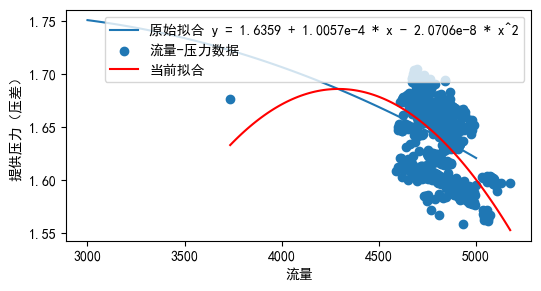

In [69]:
fit_func = []
for k in range(8):
    # print(gongpin_list[k*2],gongpin_list[k*2+1])
    sql = """
    select tagv_desc,tagv_value,tagv_fresh_time from  fz_tag_view
where tagv_desc in ('日照站出站流量检测','{}','{}') AND tagv_fresh_time LIKE '2023-0%'
ORDER BY tagv_fresh_time
    """.format(gongpin_list[k*2],gongpin_list[k*2+1])
    conn = get_conn()
    result = {}
    with conn.cursor() as cursor:
        cursor.execute(sql)
        data = cursor.fetchall()

    source_data = pd.DataFrame(data)
    source_data['time_stamp'] = source_data['tagv_fresh_time'].astype('str').apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').timestamp())


    columns = [gongpin_list[k*2],gongpin_list[k*2+1],'日照站出站流量检测']
    filter_data = pd.DataFrame(columns=columns)
    
    j=0
    # time_delta = 60*5  # 时间差
    for i in source_data[source_data['tagv_desc']=='日照站出站流量检测'].index[1:-1]: 
        filter_data.loc[j,'日照站出站流量检测'] = source_data.loc[i,'tagv_value']
        for u in range(-3,4): 
            if (source_data.loc[i+u,'tagv_desc'] in columns and abs(source_data.loc[i,'time_stamp']-source_data.loc[i+u,'time_stamp'])<time_delta):
                filter_data.loc[j,source_data.loc[i+u,'tagv_desc']] =  source_data.loc[i+u,'tagv_value']
        j+=1

    filter_data['pressure_diff'] = filter_data[columns[1]] - filter_data[columns[0]] 
#     print(filter_data)
#     break
    filter_data2 = filter_data[(filter_data['日照站出站流量检测'] > 3500) & (filter_data['pressure_diff'] > 0.3)]

    filter_data3 = filter_data2.loc[:,['日照站出站流量检测','pressure_diff']]
    if len(filter_data3)>1:
        print('开始拟合%s'%gongpin_list[k*2][4:12])
        # 提取自变量和因变量
        x = filter_data3['日照站出站流量检测'].astype("float")
        y = filter_data3['pressure_diff'].astype('float')

        # 使用polyfit进行拟合
        coefficients = np.polyfit(x, y, 2)
        a = coefficients[0]
        b = coefficients[1]
        c = coefficients[2]
        # 构建拟合方程
        fit_equation = f'y = {a:.2f} * x^2 + {b:.2f} * x + {c:.2f}'
        # 绘制数据和拟合曲线
        x_range = np.linspace(min(x), max(x), 100)
        y_fit = a * x_range ** 2 + b * x_range + c
        # 打印拟合的函数表达式
        fit_equation = f'y = {a:.12f} * x^2 + {b:.10f} * x + {c:.10f}'
        print('拟合函数为：',fit_equation)
        fit_func.append(fit_equation)

        # 画图检查
        plt.figure(figsize=(6,3))
        flow = np.linspace(3000, 5000, 100) 
        yy = do_predict(flow)
        plt.plot(flow, yy, label='原始拟合 y = 1.6359 + 1.0057e-4 * x - 2.0706e-8 * x^2')  # 原始拟合线
        plt.scatter(x, y, label='流量-压力数据')  # 散点
        plt.plot(x_range, y_fit, color='red', label='当前拟合')  # 当前拟合线

        plt.xlabel('流量')
        plt.ylabel('提供压力（压差）')
        #plt.title('Quadratic Fit')
        plt.legend()
        plt.show()
    else:
        print(source_data.iloc[0,0][0:12],'，压差全部小于0.3','，此段时间泵未开启')


In [70]:
fit_func

['y = -0.000000094675 * x^2 + 0.0007256603 * x + 0.3259694955',
 'y = -0.000000005331 * x^2 + -0.0000271323 * x + 1.9025624965',
 'y = -0.000000019866 * x^2 + 0.0000678761 * x + 1.7679022152',
 'y = -0.000000108118 * x^2 + 0.0008077043 * x + 0.2038966221',
 'y = -0.000000041413 * x^2 + 0.0002705021 * x + 1.2816978385',
 'y = -0.000000056491 * x^2 + 0.0004074756 * x + 0.9866817504',
 'y = -0.000000044731 * x^2 + 0.0002942832 * x + 1.2588246840',
 'y = -0.000000170644 * x^2 + 0.0014647177 * x + -1.4568069403']

# 变频泵 pressure = f(flow，freq)

In [2]:
# 定义目标函数
def target_function(xy, a, b, c, w):
    x, y = xy
    return (a * (x + 0.6)**2 + b * (x + 0.6) * y + c * y**2) * w

# 定义原始拟合函数
def function_to_plot(flow, freq):
    return ((freq+0.6)**2) * 1.6359 + (freq+0.6) * 1.0057 * pow(10,-4) * flow -2.0706 * pow(10,-8) * pow(flow, 2) 

In [20]:
bianpin_beng_list= ['日仪增输日照站1P-7泵入口压力检测','日仪增输日照站1P-7泵出口压力检测','日仪增输日照站1P-8泵入口压力检测','日仪增输日照站1P-8泵出口压力检测'
                   ,'日仪增输日照站1P-9泵入口压力检测','日仪增输日照站1P-9泵出口压力检测','日仪增输日照站1P-10泵入口压力检测','日仪增输日照站1P-10泵出口压力检测'
                   ,'日仪增输东海站2P_3泵入口压力检测','日仪增输东海站2P_3泵出口压力检测','日仪增输东海站2P_4泵入口压力检测','日仪增输东海站2P_4泵出口压力检测'
                   ,'日仪增输东海站2P_5泵入口压力检测','日仪增输东海站2P_5泵出口压力检测','日仪增输东海站2P_6泵入口压力检测','日仪增输东海站2P_6泵出口压力检测'
                   ,'日仪增输淮安站3P_7泵入口压力检测','日仪增输淮安站3P_7泵出口压力检测','日仪增输淮安站3P_8泵入口压力检测','日仪增输淮安站3P_8泵出口压力检测'
                   ,'日仪增输淮安站3P_9泵入口压力检测','日仪增输淮安站3P_9泵出口压力检测','日仪增输淮安站3P_10泵入口压力检测','日仪增输淮安站3P_10泵出口压力检测'
                   ,'日仪增输观音站4P_3泵入口压力检测','日仪增输观音站4P_3泵出口压力检测','日仪增输观音站4P_4泵入口压力检测','日仪增输观音站4P_4泵出口压力检测'
                   ,'日仪增输观音站4P_5泵入口压力检测','日仪增输观音站4P_5泵出口压力检测','日仪增输观音站4P_6泵入口压力检测','日仪增输观音站4P_6泵出口压力检测']
bainpinqi_list=['日仪增输日照站1#变频器频率输入','日仪增输日照站2#变频器频率输入'
               ,'日仪增输东海站1#变频器输出频率检测','日仪增输东海站2#变频器输出频率检测'
               ,'日仪增输淮安站1#变频器输出频率检测','日仪增输淮安站2#变频器输出频率检测'
               ,'日仪增输观音站1#变频器输出频率检测','日仪增输观音站2#变频器输出频率检测']

In [ ]:
bianpin_func=[]

In [38]:
m = 0
for k in range(8):
    if k %2==0:
        sql = """
            select tagv_desc,tagv_value,tagv_fresh_time from  fz_tag_view
        where tagv_desc in ('{}','{}'
                           ,'{}','{}'
                           ,'日照站出站流量检测','{}') AND ( tagv_fresh_time LIKE '2023%' or tagv_fresh_time LIKE '2022%')
        ORDER BY tagv_fresh_time
            """.format(bianpin_beng_list[k*4],bianpin_beng_list[k*4+1],bianpin_beng_list[k*4+4],bianpin_beng_list[k*4+5],bainpinqi_list[m])
    
        conn = get_conn()
        result = {}
        with conn.cursor() as cursor:
            cursor.execute(sql)
            data = cursor.fetchall()

        source_data = pd.DataFrame(data)
        source_data['time_stamp'] = source_data['tagv_fresh_time'].astype('str').apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').timestamp())

        columns = [bianpin_beng_list[k*4],bianpin_beng_list[k*4+1],bianpin_beng_list[k*4+4],bianpin_beng_list[k*4+5],'日照站出站流量检测']
        filter_data = pd.DataFrame(columns=[bianpin_beng_list[k*4],bianpin_beng_list[k*4+1],bianpin_beng_list[k*4+4],bianpin_beng_list[k*4+5],'日照站出站流量检测',bainpinqi_list[m]])


        j=0
        for i in source_data[source_data['tagv_desc']==bainpinqi_list[m]].index[1:-1]:
            filter_data.loc[j,bainpinqi_list[m]] = source_data.loc[i,'tagv_value']

            for u in range(-6,6): 
                if (source_data.loc[i+u,'tagv_desc'] in columns and abs(source_data.loc[i,'time_stamp']-source_data.loc[i+u,'time_stamp'])<time_delta):
                    filter_data.loc[j,source_data.loc[i+u,'tagv_desc']] =  source_data.loc[i+u,'tagv_value']
            j+=1  
        filter_data = filter_data.dropna()
        filter_data = filter_data[filter_data[bainpinqi_list[m]] > 20]
        
        filter_data['%s压差'%bianpin_beng_list[k*4][4:12]] = filter_data['%s'%bianpin_beng_list[k*4+1]] - filter_data['%s'%bianpin_beng_list[k*4]]
        filter_data['%s压差'%bianpin_beng_list[k*4+4][4:12]] = filter_data['%s'%bianpin_beng_list[k*4+5]] - filter_data['%s'%bianpin_beng_list[k*4+4]]

        filter_data=filter_data.loc[:,['%s压差'%bianpin_beng_list[k*4][4:12],'%s压差'%bianpin_beng_list[k*4+4][4:12],'日照站出站流量检测','%s'%bainpinqi_list[m]]]
        columns = ['压差','流量','变频器1']
        pump7=pd.DataFrame(columns=columns)

        columns = ['压差','流量','变频器1']
        pump9=pd.DataFrame(columns=columns)
        for i in range(len(filter_data)):
            if filter_data.iloc[i,0]>0.3 and filter_data.iloc[i,1]<0.3: # 开1不开2
                pump7 = pump7.append({'压差':filter_data.iloc[i,0],'流量': filter_data.iloc[i,2],'变频器1':filter_data.iloc[i,3]}, ignore_index=True)

            elif filter_data.iloc[i,0]<0.3 and filter_data.iloc[i,1]>0.3: # 开2不开1
                pump9 = pump9.append({'压差':filter_data.iloc[i,1],'流量': filter_data.iloc[i,2],'变频器1':filter_data.iloc[i,3]}, ignore_index=True)

            elif filter_data.iloc[i,0]>0.3 and filter_data.iloc[i,1]>0.3: # 都开
                if filter_data.iloc[i,0] > filter_data.iloc[i,1]:          # 大的是工频，小的是变频
                    pump9 = pump9.append({'压差':filter_data.iloc[i,1],'流量': filter_data.iloc[i,2],'变频器1':filter_data.iloc[i,3]}, ignore_index=True)
                else:
                    pump7 = pump7.append({'压差':filter_data.iloc[i,0],'流量': filter_data.iloc[i,2],'变频器1':filter_data.iloc[i,3]}, ignore_index=True)      
         # 生成原始拟合函数 数据
        flow_range = np.linspace(4000, 5000, 100)
        freq_range = np.linspace(0.09, 0.38, 100)
        flow_grid, freq_grid = np.meshgrid(flow_range, freq_range)
        z_values = function_to_plot(flow_grid, freq_grid)
        # ！！！！！！！！！！！开始拟合！！！！！！！！！！！
        nn=0
        for i in [pump7,pump9]:
            print('开始拟合%s'%bianpin_beng_list[k*4+nn*4][4:12])
            nn += 1
            if len(i)>10:
                data = i
                # 生成示例数据
                x = (data['变频器1']-30)/50
                y = data['流量']
                z = data['压差']

                # 进行拟合
                initial_guess = [1, 1, 1, 1]
                params, covariance = curve_fit(target_function, (x, y), z, p0=initial_guess)
                a_fit, b_fit, c_fit, w_fit = params

                # 生成拟合后的数据
                x_grid, y_grid = np.meshgrid(np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100))
                z_fit = target_function((x_grid, y_grid), a_fit, b_fit, c_fit, w_fit)
                # 打印拟合的函数表达式
                fit_equation = f'Fitted Equation: z = ({a_fit:.7f} * (x + 0.6)**2 + {b_fit:.7f} * (x + 0.6) * y + {c_fit:.7f} * y**2) * {w_fit:.7f}'
                print(fit_equation)

                def plot_3D1(elev=30,azim=30):
                    ax = plt.subplot(projection="3d")
                    ax.scatter3D(        y,         x,      z,     c='b',   label='Data')
                    ax.plot_surface(   y_grid,x_grid, z_fit, color='r', alpha=0.5)
                    ax.plot_surface(flow_grid, freq_grid, z_values, cmap='viridis')
                    ax.view_init(elev=elev,azim=azim)

                    ax.set_xlabel("flow")
                    ax.set_ylabel("freq")
                    ax.set_zlabel("pressure_diff")
                    plt.show()
                from ipywidgets import interact,fixed
                interact(plot_3D1,elev=[0,10,20,30,60,90],azip=(-180,180))             #设置范围
                plt.show()
            else:
                print('数据太少无法拟合函数！')
    
    if k %2!=0:
        sql = """
            select tagv_desc,tagv_value,tagv_fresh_time from  fz_tag_view
        where tagv_desc in ('{}','{}'
                           ,'{}','{}'
                           ,'日照站出站流量检测','{}') AND ( tagv_fresh_time LIKE '2023%' or tagv_fresh_time LIKE '2022%')
        ORDER BY tagv_fresh_time
            """.format(bianpin_beng_list[k*4-2],bianpin_beng_list[k*4-1],bianpin_beng_list[k*4+2],bianpin_beng_list[k*4+3],bainpinqi_list[m])
        conn = get_conn()
        result = {}
        with conn.cursor() as cursor:
            cursor.execute(sql)
            data = cursor.fetchall()

        source_data = pd.DataFrame(data)
        source_data['time_stamp'] = source_data['tagv_fresh_time'].astype('str').apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').timestamp())

        columns = [bianpin_beng_list[k*4-2],bianpin_beng_list[k*4-1],bianpin_beng_list[k*4+2],bianpin_beng_list[k*4+3],'日照站出站流量检测']
        filter_data = pd.DataFrame(columns=[bianpin_beng_list[k*4-2],bianpin_beng_list[k*4-1],bianpin_beng_list[k*4+2],bianpin_beng_list[k*4+3],'日照站出站流量检测',bainpinqi_list[m]])


        j=0
        for i in source_data[source_data['tagv_desc']==bainpinqi_list[m]].index[1:-1]:
            filter_data.loc[j,bainpinqi_list[m]] = source_data.loc[i,'tagv_value']

            for u in range(-6,6): 
                if (source_data.loc[i+u,'tagv_desc'] in columns and abs(source_data.loc[i,'time_stamp']-source_data.loc[i+u,'time_stamp'])<time_delta):
                    filter_data.loc[j,source_data.loc[i+u,'tagv_desc']] =  source_data.loc[i+u,'tagv_value']
            j+=1  

        filter_data = filter_data.dropna()
        filter_data = filter_data[filter_data[bainpinqi_list[m]] > 20]
    
        filter_data['%s压差'%bianpin_beng_list[k*4-2][4:12]] = filter_data['%s'%bianpin_beng_list[k*4-1]] - filter_data['%s'%bianpin_beng_list[k*4-2]]
        filter_data['%s压差'%bianpin_beng_list[k*4+2][4:12]] = filter_data['%s'%bianpin_beng_list[k*4+3]] - filter_data['%s'%bianpin_beng_list[k*4+2]]
        
        filter_data=filter_data.loc[:,['%s压差'%bianpin_beng_list[k*4-2][4:12],'%s压差'%bianpin_beng_list[k*4+2][4:12],'日照站出站流量检测','%s'%bainpinqi_list[m]]]
        columns = ['压差','流量','变频器1']
        pump7=pd.DataFrame(columns=columns)

        columns = ['压差','流量','变频器1']
        pump9=pd.DataFrame(columns=columns)
    
        for i in range(len(filter_data)):
            if filter_data.iloc[i,0]>0.3 and filter_data.iloc[i,1]<0.3: # 开1不开2
                pump7 = pump7.append({'压差':filter_data.iloc[i,0],'流量': filter_data.iloc[i,2],'变频器1':filter_data.iloc[i,3]}, ignore_index=True)

            elif filter_data.iloc[i,0]<0.3 and filter_data.iloc[i,1]>0.3: # 开2不开1
                pump9 = pump9.append({'压差':filter_data.iloc[i,1],'流量': filter_data.iloc[i,2],'变频器1':filter_data.iloc[i,3]}, ignore_index=True)

            elif filter_data.iloc[i,0]>0.3 and filter_data.iloc[i,1]>0.3: # 都开
                if filter_data.iloc[i,0] > filter_data.iloc[i,1]:          # 大的是工频，小的是变频
                    pump9 = pump9.append({'压差':filter_data.iloc[i,1],'流量': filter_data.iloc[i,2],'变频器1':filter_data.iloc[i,3]}, ignore_index=True)
                else:
                    pump7 = pump7.append({'压差':filter_data.iloc[i,0],'流量': filter_data.iloc[i,2],'变频器1':filter_data.iloc[i,3]}, ignore_index=True)      
        # 生成原始拟合函数 数据
        flow_range = np.linspace(4000, 5000, 100)
        freq_range = np.linspace(0.09, 0.38, 100)
        flow_grid, freq_grid = np.meshgrid(flow_range, freq_range)
        z_values = function_to_plot(flow_grid, freq_grid)
        nn =0
        for i in [pump7,pump9]:
            print('开始拟合%s'%bianpin_beng_list[k*4-2+nn*4][4:12])
            nn += 1
            if len(i)>10:
                data = i
                # 生成示例数据
                x = (data['变频器1']-30)/50
                y = data['流量']
                z = data['压差']

                # 进行拟合
                initial_guess = [1, 1, 1, 1]
                params, covariance = curve_fit(target_function, (x, y), z, p0=initial_guess)
                a_fit, b_fit, c_fit, w_fit = params

                # 生成拟合后的数据
                x_grid, y_grid = np.meshgrid(np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100))
                z_fit = target_function((x_grid, y_grid), a_fit, b_fit, c_fit, w_fit)
                # 打印拟合的函数表达式
                fit_equation = f'Fitted Equation: z = ({a_fit:.7f} * (x + 0.6)**2 + {b_fit:.7f} * (x + 0.6) * y + {c_fit:.7f} * y**2) * {w_fit:.7f}'
                print(fit_equation)
                bianpin_func.append(fit_equation)

                def plot_3D1(elev=30,azim=30):
                    ax = plt.subplot(projection="3d")
                    ax.scatter3D(        y,         x,      z,     c='b',   label='Data')
                    ax.plot_surface(   y_grid,x_grid, z_fit, color='r', alpha=0.5)
                    ax.plot_surface(flow_grid, freq_grid, z_values, cmap='viridis')
                    ax.view_init(elev=elev,azim=azim)

                    ax.set_xlabel("flow")
                    ax.set_ylabel("freq")
                    ax.set_zlabel("pressure_diff")
                    plt.show()
                from ipywidgets import interact,fixed
                interact(plot_3D1,elev=[0,10,20,30,60,90],azip=(-180,180))             #设置范围
                plt.show()
            else:
                print('数据太少无法拟合函数！')
    m += 1
    # print(sql)

开始拟合日照站1P-7泵
Fitted Equation: z = (-2652460.2327716 * (x + 0.6)**2 + -208.6294665 * (x + 0.6) * y + 0.0187294 * y**2) * -0.0000005


interactive(children=(Dropdown(description='elev', index=3, options=(0, 10, 20, 30, 60, 90), value=30), IntSli…

开始拟合日照站1P-9泵
数据太少无法拟合函数！
开始拟合日照站1P-8泵
Fitted Equation: z = (39.2999942 * (x + 0.6)**2 + 0.0020471 * (x + 0.6) * y + -0.0000003 * y**2) * 0.0400509


interactive(children=(Dropdown(description='elev', index=3, options=(0, 10, 20, 30, 60, 90), value=30), IntSli…

开始拟合日照站1P-10
Fitted Equation: z = (-1295.5442436 * (x + 0.6)**2 + 0.1048064 * (x + 0.6) * y + -0.0000056 * y**2) * -0.0017940


interactive(children=(Dropdown(description='elev', index=3, options=(0, 10, 20, 30, 60, 90), value=30), IntSli…

开始拟合东海站2P_3泵
Fitted Equation: z = (167.3397374 * (x + 0.6)**2 + -0.0017207 * (x + 0.6) * y + -0.0000003 * y**2) * 0.0110540


interactive(children=(Dropdown(description='elev', index=3, options=(0, 10, 20, 30, 60, 90), value=30), IntSli…

开始拟合东海站2P_5泵
Fitted Equation: z = (-187483.5966987 * (x + 0.6)**2 + -107.4527942 * (x + 0.6) * y + 0.0150083 * y**2) * -0.0000047


interactive(children=(Dropdown(description='elev', index=3, options=(0, 10, 20, 30, 60, 90), value=30), IntSli…

开始拟合东海站2P_4泵
Fitted Equation: z = (523567.3784744 * (x + 0.6)**2 + -209.1970785 * (x + 0.6) * y + 0.0214270 * y**2) * 0.0001318


interactive(children=(Dropdown(description='elev', index=3, options=(0, 10, 20, 30, 60, 90), value=30), IntSli…

开始拟合东海站2P_6泵
Fitted Equation: z = (37890018.3645441 * (x + 0.6)**2 + -1820.0716376 * (x + 0.6) * y + 0.0116878 * y**2) * 0.0000001


interactive(children=(Dropdown(description='elev', index=3, options=(0, 10, 20, 30, 60, 90), value=30), IntSli…

开始拟合淮安站3P_7泵
Fitted Equation: z = (-185793.4742081 * (x + 0.6)**2 + -3.3157951 * (x + 0.6) * y + 0.0009063 * y**2) * -0.0000089


interactive(children=(Dropdown(description='elev', index=3, options=(0, 10, 20, 30, 60, 90), value=30), IntSli…

开始拟合淮安站3P_9泵
Fitted Equation: z = (220829.7789553 * (x + 0.6)**2 + 11.2578268 * (x + 0.6) * y + -0.0020346 * y**2) * 0.0000072


interactive(children=(Dropdown(description='elev', index=3, options=(0, 10, 20, 30, 60, 90), value=30), IntSli…

开始拟合淮安站3P_8泵
Fitted Equation: z = (-122246.6054944 * (x + 0.6)**2 + -44.4958415 * (x + 0.6) * y + 0.0047474 * y**2) * -0.0000075


interactive(children=(Dropdown(description='elev', index=3, options=(0, 10, 20, 30, 60, 90), value=30), IntSli…

开始拟合淮安站3P_10
数据太少无法拟合函数！
开始拟合观音站4P_3泵
Fitted Equation: z = (-276271.7589354 * (x + 0.6)**2 + -12.8700326 * (x + 0.6) * y + 0.0029378 * y**2) * -0.0000064


interactive(children=(Dropdown(description='elev', index=3, options=(0, 10, 20, 30, 60, 90), value=30), IntSli…

开始拟合观音站4P_5泵
Fitted Equation: z = (66.5218345 * (x + 0.6)**2 + 0.0014976 * (x + 0.6) * y + -0.0000004 * y**2) * 0.0272683


interactive(children=(Dropdown(description='elev', index=3, options=(0, 10, 20, 30, 60, 90), value=30), IntSli…

开始拟合观音站4P_4泵
Fitted Equation: z = (-483.3216402 * (x + 0.6)**2 + 0.1366338 * (x + 0.6) * y + -0.0000132 * y**2) * -0.0127857


interactive(children=(Dropdown(description='elev', index=3, options=(0, 10, 20, 30, 60, 90), value=30), IntSli…

开始拟合观音站4P_6泵
Fitted Equation: z = (-9181152.7520526 * (x + 0.6)**2 + 267.0006291 * (x + 0.6) * y + 0.0100057 * y**2) * -0.0000002


interactive(children=(Dropdown(description='elev', index=3, options=(0, 10, 20, 30, 60, 90), value=30), IntSli…